# Section 4. Python Web APIs

#### Instructor: Pierre Biscaye 

The objective of this notebook is to introduce you to some basic steps for extracting data from the web with APIs using Python, focusing on the New York Times API as a case study. The content of this notebook is taken from UC Berkeley D-Lab's Python Web APIs [course](https://github.com/dlab-berkeley/Python-Web-APIs).

### Learning Objectives
1. The New York Times API
2. Top stories API
3. Most Popular API
4. Article Search API
5. Examples of Data Analysis
6. Another example: IMF API

### Libraries loaded
* matplotlib.pyplot
* datetime
* time
* numpy
* pandas
* configparser
* os
* getpass
* requests
* pynytimes
* Counter
* seaborn
* vadersentiment
* ast
* scipy

In [1]:
# Import basic required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

# 1. Setting up The New York Times API

We are going to use the NYT API to demonstrate how Web APIs can be used to access useful information in an easy way. Before proceeding with this lesson, you should have already set up an API key following the instructions in Web APIs overview slides. Copy that API key now.

## Handling API Keys

API keys are sensitive data! You **do not** want to accidentally share them publicly. This includes not pasting your API key directly into a notebook where it can be read.

The following cell will:

1. First try to obtain previously saved credentials by loading with `configparser`;
2. If not found, use `getpass` to request the credentials from the user (which works in notebooks as an input prompt);
3. Then save those user-inputted credentials using configparser to `~/.notebook-api-keys` which is outside of the directory for this notebook so it doesn't accidentally get uploaded publicly. In particular, it will save this to your main user directory.
   
Run the following cell and add the API Key you just created when prompted.

In [9]:
import configparser
import os
from getpass import getpass

def get_api_key(api_name):
    config_file_path = os.path.expanduser("~/.notebook-api-keys")
    config = configparser.ConfigParser(interpolation=None)  # Disable interpolation to avoid issues with special characters
    
    # Try reading the existing config file
    if os.path.exists(config_file_path):
        config.read(config_file_path)
    
    # Check if API key is present
    if config.has_option("API_KEYS", api_name):
        # Ask if the user wants to update the key
        update_key = input(f"An API key for {api_name} already exists. Do you want to update it? (y/n): ").lower()
        if update_key == 'n':
            return config.get("API_KEYS", api_name)
    
    # If no key exists or user opts to update, prompt for the new key
    api_key = getpass(f"Enter your {api_name} API key: ")

    # Save the API key in the config file
    if not config.has_section("API_KEYS"):
        config.add_section("API_KEYS")
    config.set("API_KEYS", api_name, api_key)
    
    with open(config_file_path, "w") as f:
        config.write(f)
    
    return api_key

# Example usage to retrieve the NYT API key
api_key = get_api_key("NYT")

print("NYT API key retrieved successfully.")


An API key for NYT already exists. Do you want to update it? (y/n):  y
Enter your NYT API key:  ········


NYT API key retrieved successfully.


### Efficient loading of API keys

Note that `~/.notebook-api-keys` can save keys for multiple APIs.

We would need to run a version of this any time you have a new API key to save, or want to use a particular API tool. With that in mind, let's do a few things:
1. Generalize the code (so it's not specific to the NYT API).
2. Make "updating" the key an optional parameter so that it doesn't get asked each time.
3. Save the code to a `.py` script you can then import in other notebooks.

Below is a cleaner updated version of the code.

In [10]:
import configparser
import os
from getpass import getpass

def get_api_key(api_name, force_update=False):
    """
    Retrieves an API key. Prompts user only if the key is missing 
    or if force_update is True.
    """
    config_file_path = os.path.expanduser("~/.notebook-api-keys")
    config = configparser.ConfigParser(interpolation=None)
 
    # Try reading the existing config file
    if os.path.exists(config_file_path):
        config.read(config_file_path)
    
    # Check if key exists AND we aren't forcing an update
    if config.has_option("API_KEYS", api_name) and not force_update:
        return config.get("API_KEYS", api_name)
    
    # Otherwise, prompt for the key
    api_key = getpass(f"Enter your {api_name} API key: ")

    # Save the API key in the config file
    if not config.has_section("API_KEYS"):
        config.add_section("API_KEYS")
    config.set("API_KEYS", api_name, api_key)
    
    # Save the updated config file
    with open(config_file_path, "w") as f:
        config.write(f)
    
    return api_key

Save this as `api_utils.py` file in this notebook's directory, then try the below code.

Note that this code runs *silently*, retrieving the key without displaying anything, unless there is no key or you are forcing an update.

In [11]:
from api_utils import get_api_key

# This will check the hidden file. If it's not there, it asks. 
# If it IS there, it just returns it silently.
nyt_key = get_api_key("NYT")

How can you check that this code returned the same thing as our original code?

In [5]:
# Your code here

## Loading `pynytimes`

To access the NYTimes' databases, we'll be using a third-party library called [pynytimes](https://github.com/michadenheijer/pynytimes). This package provides an easy to use tool for accessing the wealth of data hosted by the Times.

We installed this library using pip in our `environment.yaml` file. 

Let's go ahead import the library and initialize a connection to their servers using our api key.

In [12]:
# Import the NYTAPI object which we'll use to access the API
from pynytimes import NYTAPI

In [13]:
# Intialize the NYT API class into an object using your API key
nyt = NYTAPI(api_key, parse_dates=True)

We are now ready to make some API calls!

Now that we've established a connection to New York Times' rich database, let's go over what kind of data and privileges we have access to.
 
 ### APIs

[Here is the collection of the APIs the NYT gives us:](https://developer.nytimes.com/apis)

- [Archive metadata](https://developer.nytimes.com/docs/archive-product/1/overview): Returns an array of NYT articles for a given month, going back to 1851.
- [Article search](https://developer.nytimes.com/docs/articlesearch-product/1/overview): Look up articles by keyword. You can refine your search using filters and facets.
- [Books](https://developer.nytimes.com/docs/books-product/1/overview): Provides information about book reviews and The New York Times Best Sellers lists.
- [Most popular articles](https://developer.nytimes.com/docs/most-popular-product/1/overview): Provides services for getting the most popular articles on NYTimes.com based on emails, shares, or views.
- [RSS feeds](https://developer.nytimes.com/docs/rss-api/1/overview): Returns articles ranked on the section fronts (Arts, HomePage, World, ...)
- [Times Wire](https://developer.nytimes.com/docs/timeswire-product/1/overview): Get links and metadata for Times' articles as soon as they are published on NYTimes.com. The Times Newswire API provides an up-to-the-minute stream of published articles.
- [Top stories](https://developer.nytimes.com/docs/top-stories-product/1/overview): Returns an array of articles currently on the specified section 

We will look at a few of these today.

# 2. Top Stories API

Let's look at the top stories of the day. All we have to do is call a single method on the `nyt` object:

In [14]:
# Get all the top stories from the home page
top_stories = nyt.top_stories()

print(f"top_stories is a list of length {len(top_stories)}")

top_stories is a list of length 25


When working with a new API, a good way to establish an understanding of the data is to inspect a single object in the collection. Let's grab the first story in the list and inspect its attributes and data:

In [15]:
top_story = top_stories[0]
top_story

{'section': 'us',
 'subsection': 'politics',
 'title': 'A Crisis of Confidence for ICE and Border Patrol as Clashes Escalate',
 'abstract': 'Current and former officials describe growing frustration and disillusionment with the Trump administration’s approach, even as they support the goal of immigration enforcement.',
 'url': 'https://www.nytimes.com/2026/01/26/us/politics/ice-border-patrol-trust.html',
 'uri': 'nyt://article/c83e5406-ad20-5fca-91bb-faa71dd31f55',
 'byline': 'By Nicholas Nehamas, Hamed Aleaziz, Zolan Kanno-Youngs and Alexandra Berzon',
 'item_type': 'Article',
 'updated_date': datetime.datetime(2026, 1, 26, 7, 1, 42, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))),
 'created_date': datetime.datetime(2026, 1, 26, 5, 2, 49, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))),
 'published_date': datetime.datetime(2026, 1, 26, 5, 2, 49, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))),
 'material_type_facet': ''

This is pretty typical output for data pulled from an API. We are looking at a list of nested JSON dictionaries.

We are provided a diverse collection of data for the article ranging from the expected (title, author (byline), date, section), to keywords (organized by facet), and included media. Notice that the full article itself is not included - the API does not provide that to us.

We can call specific elements of these results.

In [16]:
print(top_story['title'])
print(top_story['org_facet'])

A Crisis of Confidence for ICE and Border Patrol as Clashes Escalate
['Border Patrol (US)', 'Customs and Border Protection (US)', 'Homeland Security Department', 'Immigration and Customs Enforcement (US)']


## Organizing the API Results into a `pandas` DataFrame

In order to conduct subsequent data analysis, we need to convert the list of JSON data to a `pandas` DataFrame. `pandas` allows us to simply pass in the JSON list and produce a clean table in one line of code. 

First, let's see what happens when we pass in `top_stories` to `pd.json_normalize`:

In [17]:
# Convert to DataFrmae
df = pd.json_normalize(top_stories)
# View the first 5 rows
df.head()

,section,subsection,title,abstract,url,uri,byline,item_type,updated_date,created_date,published_date,material_type_facet,kicker,des_facet,org_facet,per_facet,geo_facet,multimedia,short_url
0,us,politics,A Crisis of Confidence for ICE and Border Patr...,Current and former officials describe growing ...,https://www.nytimes.com/2026/01/26/us/politics...,nyt://article/c83e5406-ad20-5fca-91bb-faa71dd3...,"By Nicholas Nehamas, Hamed Aleaziz, Zolan Kann...",Article,2026-01-26 07:01:42-05:00,2026-01-26 05:02:49-05:00,2026-01-26 05:02:49-05:00,,,"[Illegal Immigration, Police Brutality, Miscon...","[Border Patrol (US), Customs and Border Protec...","[Biden, Joseph R Jr, Good, Renee Nicole (1988-...",[Minneapolis (Minn)],[{'url': 'https://static01.nyt.com/images/2026...,
1,us,,Alex Pretti’s Friends and Family Denounce ‘Sic...,People who knew a man fatally shot by federal ...,https://www.nytimes.com/2026/01/25/us/alex-pre...,nyt://article/012ef3b2-8ade-538f-8785-200e8cfe...,"By Talya Minsberg, Corina Knoll and Julie Bosman",Article,2026-01-26 07:27:51-05:00,2026-01-25 20:38:58-05:00,2026-01-25 20:38:58-05:00,,,"[Police Brutality, Misconduct and Shootings, I...","[Immigration and Customs Enforcement (US), Vet...","[Pretti, Alex Jeffrey (1988-2026)]","[Minneapolis (Minn), Minnesota]",[{'url': 'https://static01.nyt.com/images/2026...,
2,us,politics,How the Trump Administration Rushed to Judgmen...,The administration was in a race to control th...,https://www.nytimes.com/2026/01/25/us/politics...,nyt://article/bf2c79f2-62bd-5a6a-925e-3208cbfe...,By Tyler Pager and Hamed Aleaziz,Article,2026-01-26 04:41:48-05:00,2026-01-25 19:59:20-05:00,2026-01-25 19:59:20-05:00,,,"[Police Brutality, Misconduct and Shootings, F...","[Border Patrol (US), Immigration and Customs E...","[Bovino, Gregory, Blanche, Todd (Attorney), Go...",[Minneapolis (Minn)],[{'url': 'https://static01.nyt.com/images/2026...,
3,podcasts,the-headlines,Trump Administration Tries to Control Minneapo...,"Plus, High January is the new Dry January.",https://www.nytimes.com/2026/01/26/podcasts/th...,nyt://article/04b31066-1469-5baa-829e-9bf48bfb...,"By Tracy Mumford, Will Jarvis and Ian Stewart",Article,2026-01-26 06:00:10-05:00,2026-01-26 06:00:10-05:00,2026-01-26 06:00:10-05:00,,,"[United States Politics and Government, Snow a...",[],"[Trump, Donald J]",[Minneapolis (Minn)],[{'url': 'https://static01.nyt.com/images/2026...,
4,us,,Storm Dumps a Foot of Snow in at Least 17 U.S....,"Bonito Lake, N.M., received 31 inches, the mos...",https://www.nytimes.com/2026/01/25/us/snow-tot...,nyt://article/b680c566-6e71-581a-9fae-983001d9...,By Andy Newman,Article,2026-01-26 06:50:18-05:00,2026-01-25 23:13:54-05:00,2026-01-25 23:13:54-05:00,,,[Snow and Snowstorms],[],[],"[Pennsylvania, New Mexico, United States]",[{'url': 'https://static01.nyt.com/images/2026...,


In [18]:
# Inspect the metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   section              25 non-null     object                   
 1   subsection           25 non-null     object                   
 2   title                25 non-null     object                   
 3   abstract             25 non-null     object                   
 4   url                  25 non-null     object                   
 5   uri                  25 non-null     object                   
 6   byline               25 non-null     object                   
 7   item_type            25 non-null     object                   
 8   updated_date         25 non-null     datetime64[ns, UTC-05:00]
 9   created_date         25 non-null     datetime64[ns, UTC-05:00]
 10  published_date       25 non-null     datetime64[ns, UTC-05:00]
 11  material

For the most part, `pandas` does a good job of producing a table where:

- The columns correspond with the JSON dictionary keys from our API call.
- The number of rows matches the number of articles.
- Each cell holds the corresponding value found under that article's dictionary key.

What can we do with this? As an example, let's pull the information on individual 'persons' reported in the top stories by the API, and plot the frequency with which different persons appear.

In [19]:
from collections import Counter

# Flatten the list of lists into a single list
all_words = [word for sublist in df['per_facet'] for word in sublist]

# Count occurrences of each unique string
word_counts = Counter(all_words)

# Get the 10 most common strings
top_10_words = word_counts.most_common(10)

# Convert to DataFrame for easy plotting
top_10_df = pd.DataFrame(top_10_words, columns=["word", "count"])

# Truncate long strings for readability on plot
top_10_df["short_word"] = top_10_df["word"].apply(lambda x: x[:15] + "..." if len(x) > 15 else x)

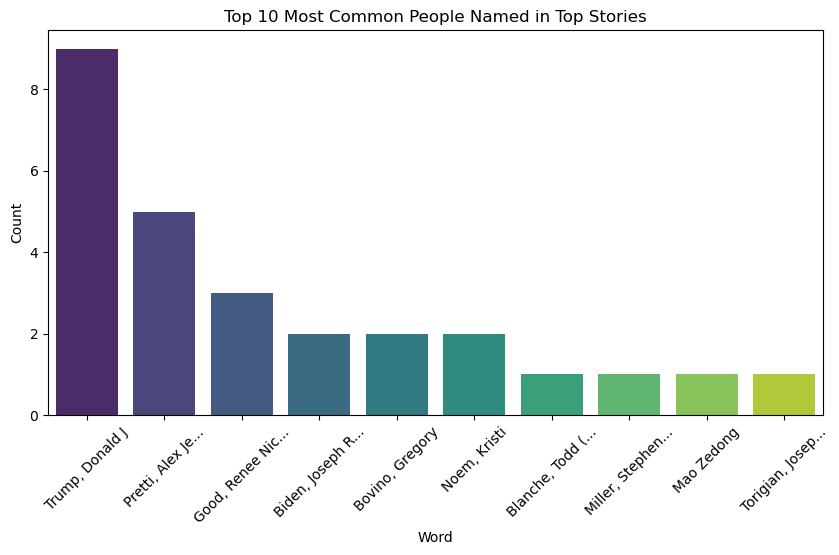

In [20]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_df, x="short_word", y="count", hue="word", palette="viridis", legend=False)
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 10 Most Common People Named in Top Stories")
plt.xticks(rotation=45)
plt.show()

The `top_stories` method has a single parameter called `section` that defaults to "home".

If we are interested in a specific section, we can pass in one of the following tags into the `section` parameter:
```arts```, ```automobiles```, ```books```, ```business```, ```fashion```, ```food```, ```health```, ```home```, ```insider```, ```magazine```, ```movies```, ```national```, ```nyregion```, ```obituaries```, ```opinion```, ```politics```, ```realestate```, ```science```, ```sports```, ```sundayreview```, ```technology```, ```theater```, ```tmagazine```, ```travel```, ```upshot```, and ```world```.


In [21]:
top_business = nyt.top_stories('business')
len(top_business)

25

Write some code to convert these results into a dataframe, and adapt the code to above to plot the top 10 most commonly names organizations in these stories.

In [22]:
# your code here

# 3. Most Popular API

Retrieving the most viewed and shared articles is also quite simple. The `days` parameter returns the most popular articles based on the last $N$ days. Keep in mind, however, that `days` can only take on one of three values: 1, 7, or 30.

Below we will retreive the most viewed articles for today.

Note that each time we run a method on `nyt`, this is referred to as an **API call**. For the NYT Article API, we have somewhat strict rate limits: 500 requests per day and 5 requests per minute (recently changed from 10 per minute and 4000 per day). You should always bear this in mind when working with APIs, and structure your code to ensure you do not exceed your limits.

In [23]:
# Retrieve the most viewed articles for today.
# The days parameter defaults to 1
most_viewed_today = nyt.most_viewed()
print(f"Title: {most_viewed_today[0]['title']}")
print(f"Section: {most_viewed_today[0]['section']}")
most_viewed_today[0]

Title: Trump Just Proved Carney’s Point
Section: Opinion


{'uri': 'nyt://article/9b81fa18-597f-5996-a106-8b6cfbe5ae75',
 'url': 'https://www.nytimes.com/2026/01/25/opinion/trump-carney-davos-canada-greenland.html',
 'id': 100000010664731,
 'asset_id': 100000010664731,
 'source': 'New York Times',
 'published_date': datetime.date(2026, 1, 25),
 'updated': datetime.datetime(2026, 1, 25, 9, 5, 9),
 'section': 'Opinion',
 'subsection': '',
 'nytdsection': 'opinion',
 'adx_keywords': 'United States Politics and Government;Territorial Disputes;United States International Relations;Right-Wing Extremism and Alt-Right;International Trade and World Market;Trump, Donald J;Carney, Mark J;World Economic Forum;Canada;United States',
 'column': None,
 'byline': 'By Ezra Klein',
 'type': 'Article',
 'title': 'Trump Just Proved Carney’s Point',
 'abstract': 'Canada’s prime minister sees the president all too well.',
 'des_facet': ['United States Politics and Government',
  'Territorial Disputes',
  'United States International Relations',
  'Right-Wing Extrem

For this piece of data, we can consult a guide or what's known as a schema to understand the information at our finger tips.

The [Most Viewed Schema](https://developer.nytimes.com/docs/most-popular-product/1/types/ViewedArticle) can answer any questions we may have about the data provided by this API:

| Attribute      | Data Type | Definition      |
| ----------- | ----------- | ----------- |
| url      | string       | Article's URL.       |
| adx_keywords   | string        | Semicolon separated list of keywords.        |
| column   | string        | Deprecated. Set to null.        |
| section   | string        | Article's section (e.g. Sports).        |
| byline   | string        | Article's byline (e.g. By Thomas L. Friedman).        |
| type   | string        | Asset type (e.g. Article, Interactive, ...).        |
| title   | string        | Article's headline (e.g. When the Cellos Play, the Cows Come Home).        |
| abstract   | string        | Brief summary of the article.|
| published_date   | string        | When the article was published on the web (e.g. 2021-04-19).        |
| source   | string        | Publisher (e.g. New York Times).        |
| id   | integer        | Asset ID number (e.g. 100000007772696).        |
| asset_id   | integer        | Asset ID number (e.g. 100000007772696).        |
| des_facet   | array        | Array of description facets (e.g. Quarantine (Life and Culture)).        |
| org_facet   | array        | Array of organization facets (e.g. Sullivan Street Bakery).        |
| per_facet   | array        | Array of person facets (e.g. Bittman, Mark).        |
| geo_facet   | array        | Array of geographic facets (e.g. Canada).        |
| media   | array        | Array of images.        |
| media.type   | string        | Asset type (e.g. image).        |
| media.subtype   | string        | Asset subtype (e.g. photo).        |
| media.caption   | string        | Media caption        |
| media.copyright   | string        | Media credit        |
| media.approved_for_syndication   | boolean        | Whether media is approved for syndication.        |
| media.media-metadata   | array        | Media metadata (url, width, height, ...).        |
| media.media-metadata.url   | string        | Image's URL.        |
| media.media-metadata.format   | string        | Image's crop name     |
| media.media-metadata.height   | integer        | Image's height |
| media.media-metadata.width   | integer        | Image's width      |

How many stories are provided to us via this function call?

In [24]:
len(most_viewed_today)

20

To pull most popular articles for the past week and month, we pass the numbers 7 or 30 into `days`

In [25]:
most_viewed_week = nyt.most_viewed(days=7)
len(most_viewed_week)

20

Note that the API only results in 20 articles, and this is not a parameter we can modify.

What is the most viewed article of the last week?

In [26]:
most_viewed_week[0]['title']

'F.B.I. Agent Who Tried to Investigate ICE Officer in Shooting Resigns'

What individuals occurred most commonly in the most-viewed articles?

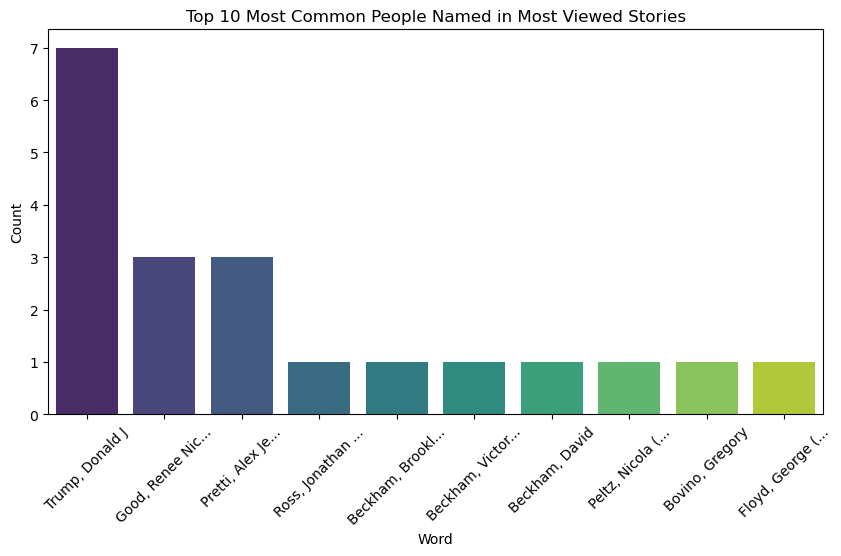

In [27]:
df2 = pd.json_normalize(most_viewed_week)

# Flatten the list of lists into a single list
all_words = [word for sublist in df2['per_facet'] for word in sublist]

# Count occurrences of each unique string
word_counts = Counter(all_words)

# Get the 10 most common strings
top_10_words = word_counts.most_common(10)

# Convert to DataFrame for easy plotting
top_10_df = pd.DataFrame(top_10_words, columns=["word", "count"])

# Truncate long strings for readability on plot
top_10_df["short_word"] = top_10_df["word"].apply(lambda x: x[:15] + "..." if len(x) > 15 else x)

# Plot it
plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_df, x="short_word", y="count", hue="word", palette="viridis", legend=False)
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 10 Most Common People Named in Most Viewed Stories")
plt.xticks(rotation=45)
plt.show()

Now let's look at the most *shared* stories. Here we can search by sharing methods.

In [28]:
# Get most shared stories
email = nyt.most_shared(days=30, method = 'email')
facebook = nyt.most_shared(days=30, method = 'facebook')
len(facebook)

20

In [29]:
# Look at the structure
email[0]

{'uri': 'nyt://article/1d0c2413-911b-50ec-8e17-17f5728b9ab3',
 'url': 'https://www.nytimes.com/2025/12/31/movies/2025-best-movies-marty-supreme.html',
 'id': 100000010608083,
 'asset_id': 100000010608083,
 'source': 'New York Times',
 'published_date': datetime.date(2025, 12, 31),
 'updated': datetime.datetime(2026, 1, 2, 15, 18, 52),
 'section': 'Movies',
 'subsection': '',
 'nytdsection': 'movies',
 'adx_keywords': 'Movies;Two Thousand Twenty Five;internal-open-access-from-nl',
 'column': None,
 'byline': 'By Stephanie Goodman',
 'type': 'Article',
 'title': 'The Top Movies of 2025, According to Times Readers',
 'abstract': 'We asked you to vote on the best films of the year. The results ranged from big box office hits to small art-house indies.',
 'des_facet': ['Movies',
  'Two Thousand Twenty Five',
  'internal-open-access-from-nl'],
 'org_facet': [],
 'per_facet': [],
 'geo_facet': [],
 'media': [{'type': 'image',
   'subtype': 'photo',
   'caption': '',
   'copyright': 'Netflix; 

In [30]:
# Get unique identifier for each story
email_ids = [story["uri"] for story in email]
facebook_ids = [story["uri"] for story in facebook]

In [31]:
# Calculate the intersection of unique IDs
len(set(email_ids).intersection(set(facebook_ids)))

1

**Question**: How do we interpret the result of the last line of code?

# 4. Article Search API

The previous results are interesting but likely seem a bit restricted. Let's take it up a notch and use the search API to retrieve a set of articles about a particular topic in a chosen period of time.

We'll use the `article_search` function. Two relevant parameters include:

- `query`: The search query
- `results`: Number of articles returned. The default is 10.

Let's try pulling the 20 most recent articles about Tanzania:

In [32]:
articles = nyt.article_search(query="Tanzania", results=20)
len(articles)

10

We asked for 20 articles, but only got 10! Why is this the case? 

The `article_search` method now returns results in "pages" of 10 articles each. Older versions of `pynytimes` would automatically loop through pages until you hit the targeted number of results. To retrieve more results, we need to do this explicitly, and keep in mind our rate limits: 5 calls per minute and 500 per day.

Why is the NYT doing this? They want to prevent people from scraping their entire history for free to train AI models. The free API tier is now much harder to use for bulk downloads than it was even one year ago.

We can handle these rate limits and pagination constraints directly by writing a loop and including a sleep timer to make sure we don't make the calls too quickly. 

Let's run the code below searching for the first 50 results about the Paris Olympics during a specific timeframe last year, and then discuss what it does.

In [33]:
import time

# 1. Setup your parameters
query_term = "Paris Olympics"
begin = datetime(2024, 7, 25) # July 25, 2024
end = datetime(2024, 8, 12) # August 12, 2024
date_dict = {"begin": begin, "end": end}
all_articles = []

# 2. Loop to get 5 pages (10 articles per page = 50 total)
for page_num in range(5):
    print(f"Fetching page {page_num}...")
    
    try:
        # We pass the specific page number in the options
        results = nyt.article_search(
            query=query_term,
            dates=date_dict,
            results=10, # Requesting 10 at a time is safer
            options={"page": page_num}
        )
        
        if results:
            all_articles.extend(results)
            print(f"Successfully retrieved {len(results)} articles.")
        else:
            print(f"No more results found on page {page_num + 1}. Ending loop.")
            break
            
    except Exception as e:
        print(f"An error occurred on page {page_num + 1}: {e}")
        break

    # 3. The "Polite Scraper" pause
    if page_num < 4:  # No need to sleep after the last page
        print("Sleeping for 12 seconds to respect rate limits...")
        time.sleep(12)

print(f"\nFinished! Total articles collected: {len(all_articles)}")

Fetching page 0...
Successfully retrieved 10 articles.
Sleeping for 12 seconds to respect rate limits...
Fetching page 1...
Successfully retrieved 10 articles.
Sleeping for 12 seconds to respect rate limits...
Fetching page 2...
Successfully retrieved 10 articles.
Sleeping for 12 seconds to respect rate limits...
Fetching page 3...
Successfully retrieved 10 articles.
Sleeping for 12 seconds to respect rate limits...
Fetching page 4...
Successfully retrieved 10 articles.

Finished! Total articles collected: 50


Let's look at the first 10 main headlines of these articles:

In [34]:
headlines = [article['headline']['main'] for article in all_articles]
headlines[:10]

['Why Afghanistan Shouldn’t Compete in the Paris Olympics',
 'Paris Olympics: Who Leads the Medal Count?',
 'These were the most unforgettable moments from the Paris Olympics.',
 'The Summer Olympics: How to Watch. What to Watch.',
 'The Olympics, a Triumph of Ambition, Lift France From Its Gloom',
 'Hip-Hop Arrives at the Paris Olympics With Breaking’s Debut',
 'Kremlin Uses Olympic Ban as Another Arrow to Shoot at the West',
 'Highlights From the 2024 Paris Olympics',
 'How Will Breaking Be Scored at the Olympics?',
 'Australian Field Hockey Player Amputates Finger to Play in the Olympics']


Notice that not all article data comes in the same format. Data from the search API is presented differently from that of the Most Popular and Top Stories APIs.

Let's look at an example below. We can explore the schemas to understand the content.

- [Article Schema](https://developer.nytimes.com/docs/articlesearch-product/1/types/Article)
- [Byline](https://developer.nytimes.com/docs/articlesearch-product/1/types/Byline)
- [Headline](https://developer.nytimes.com/docs/articlesearch-product/1/types/Headline)
- [Keyword](https://developer.nytimes.com/docs/articlesearch-product/1/types/Keyword)
- [Multimedia](https://developer.nytimes.com/docs/articlesearch-product/1/types/Multimedia)
- [Person](https://developer.nytimes.com/docs/articlesearch-product/1/types/Person)

In [35]:
all_articles[0]

{'abstract': 'That nation’s first female Olympian argues that Taliban rule is disqualifying.',
 'byline': {'original': 'By Friba Rezayee and Derek Arthur'},
 'document_type': 'article',
 'headline': {'main': 'Why Afghanistan Shouldn’t Compete in the Paris Olympics',
  'kicker': '',
  'print_headline': ''},
 '_id': 'nyt://article/d14635d5-9d12-58c0-91a5-36a9eddb8fad',
 'keywords': [{'name': 'Subject',
   'value': 'audio-neutral-informative',
   'rank': 1},
  {'name': 'Subject', 'value': 'Olympic Games', 'rank': 2},
  {'name': 'Subject', 'value': 'Olympic Games (2024)', 'rank': 3},
  {'name': 'Location', 'value': 'Paris (France)', 'rank': 4},
  {'name': 'Location', 'value': 'Afghanistan', 'rank': 5},
  {'name': 'Organization', 'value': 'Taliban', 'rank': 6},
  {'name': 'Subject', 'value': 'Women and Girls', 'rank': 7},
  {'name': 'Organization',
   'value': 'International Olympic Committee',
   'rank': 8},
  {'name': 'Subject', 'value': "Women's Rights", 'rank': 9},
  {'name': 'Subject',

You can see how this could be a powerful tool for data search. But we also see how call limits constrain what we are able to access over a given period of time.

# 5. Data Analysis

Now, we'll perform some analysis on a database of articles published about the 2024 United States presidential election.

We will work with a previously queried set of 1919 articles because making the API call in class will take too much time, and will exceed current rate limits. 

An updated version of the code used to query the articles we'll analyze can be found in the following cell. This code returns only 500 articles to respect the daily maximum. This requires browsing 50 pages of results. At 5 calls per minute, this code would take 10 minutes to run. 

Feel free to adapt it for future queries. Keep in mind your **API call and rate limits**.

## Query Using the Article Search API

In [36]:
# Change this variable if you'd like to run the query yourself; note it can take a long time to run
run_query = False

# Only run this code if you're able to wait for the query to finish
if run_query:
    
    # Set parameters
    query_term = "presidential election"
    n_results = 500
    pages_to_fetch = n_results // 10
    begin = datetime(2024, 9, 7) # September 7, 2020
    end = datetime(2024, 11, 7) # November 7, 2020
    date_dict = {"begin": begin, "end": end}

    articles = []   

    # Run the search
    for page in range(pages_to_fetch):
        print(f"Fetching page {page + 1} of {pages_to_fetch}...")
        
        try:
            # We must pass the page number inside the options dictionary
            options_dict = {
                "sort": "oldest",
                "sources": ["New York Times"],
                "type_of_material": ["News Analysis", "News", "Article", "Editorial"],
                "page": page
            }

            results = nyt.article_search(
                query=query_term,
                results=10, # Explicitly ask for one page's worth
                dates=date_dict,
                options=options_dict
            )

            if results:
                articles.extend(results)
            else:
                print("No more results returned from API. Stopping.")
                break

        except Exception as e:
            print(f"Error on page {page + 1}: {e}")
            # If we hit a rate limit error, we want to save what we have so far
            break

        # The 12-second rate limit pause
        if page < (pages_to_fetch - 1):
            time.sleep(12)

    # Create DataFrame from the collected list
    if articles:
        df = pd.json_normalize(articles)
        
        # Ensure 'lead_paragraph' column has no NaN 
        if 'lead_paragraph' in df.columns:
            df['lead_paragraph'] = df['lead_paragraph'].fillna('')
        
        # Save DataFrame
        df.to_csv("Data/election2024_articles.csv", index=False)
        print(f"Successfully saved {len(df)} articles to Data/election2024_articles.csv")
    else:
        print("No articles were collected.")

Let's load in the previously saved data:

In [37]:
election = pd.read_csv("Data/election2024_articles.csv")
election.head()

,Unnamed: 0,abstract,web_url,snippet,lead_paragraph,source,multimedia,keywords,pub_date,document_type,...,headline.content_kicker,headline.print_headline,headline.name,headline.seo,headline.sub,byline.original,byline.person,byline.organization,print_section,print_page
0,0,Speaking to the national board of the Fraterna...,https://www.nytimes.com/2024/09/06/us/politics...,Speaking to the national board of the Fraterna...,Former President Donald J. Trump urged the boa...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'subject', 'value': 'Presidential El...",2024-09-07 00:51:06+00:00,article,...,NaN,NaN,NaN,NaN,NaN,By Michael Gold and Nick Corasaniti,"[{'firstname': 'Michael', 'middlename': None, ...",NaN,NaN,NaN
1,1,"In an interview, the former British prime mini...",https://www.nytimes.com/2024/09/07/world/europ...,"In an interview, the former British prime mini...","Tony Blair is out with a new book, “On Leaders...",The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'subject', 'value': 'International R...",2024-09-07 07:12:39+00:00,article,...,NaN,Former British Leader’s New Book Could Serve a...,NaN,NaN,NaN,By Mark Landler,"[{'firstname': 'Mark', 'middlename': None, 'la...",NaN,A,8.0
2,2,"Drug dealers, scammers and white nationalists ...",https://www.nytimes.com/2024/09/07/technology/...,"Drug dealers, scammers and white nationalists ...",Telegram has become a global sewer of criminal...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'organizations', 'value': 'Telegram ...",2024-09-07 09:01:40+00:00,article,...,NaN,A Playground For Criminals And Extremists,NaN,NaN,NaN,"By Paul Mozur, Adam Satariano, Aaron Krolik an...","[{'firstname': 'Paul', 'middlename': None, 'la...",NaN,A,1.0
3,3,The right-wing think tank has been pushing mis...,https://www.nytimes.com/2024/09/07/us/politics...,The right-wing think tank has been pushing mis...,"In July, two men went door to door at a sprawl...",The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'subject', 'value': 'Presidential El...",2024-09-07 09:02:17+00:00,article,...,NaN,Right-Wing Think Tank Issues Deceptive Videos ...,NaN,NaN,NaN,By Ken Bensinger and Richard Fausset,"[{'firstname': 'Ken', 'middlename': None, 'las...",NaN,A,18.0
4,4,Federal prosecutors say Russia paid an America...,https://www.nytimes.com/2024/09/07/business/me...,Federal prosecutors say Russia paid an America...,"In early 2022, a young couple from Canada, Lau...",The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'glocations', 'value': 'Russia', 'ra...",2024-09-07 09:02:39+00:00,article,...,NaN,"Russian Cash, And Influence On Influencers",NaN,NaN,NaN,"By Steven Lee Myers, Ken Bensinger and Jim Rut...","[{'firstname': 'Steven', 'middlename': 'Lee', ...",NaN,A,1.0


In [38]:
# Inspect metadata
election.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1919 non-null   int64  
 1   abstract                 1919 non-null   object 
 2   web_url                  1919 non-null   object 
 3   snippet                  1918 non-null   object 
 4   lead_paragraph           1918 non-null   object 
 5   source                   1919 non-null   object 
 6   multimedia               1919 non-null   object 
 7   keywords                 1919 non-null   object 
 8   pub_date                 1919 non-null   object 
 9   document_type            1919 non-null   object 
 10  news_desk                1919 non-null   object 
 11  section_name             1919 non-null   object 
 12  subsection_name          1336 non-null   object 
 13  type_of_material         1919 non-null   object 
 14  _id                     

## Perform Sentiment Analysis

Sentiment analysis is a common task when working with text data. Let's track the sentiment of articles about the election over the two month time period. We'll use the `vadersentiment` package to evaluate the sentiment of each article.

According to the [VADER Github Repo](https://github.com/cjhutto/vaderSentiment), "VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is *specifically attuned to sentiments expressed in social media*."

We'll start by import the sentiment intensity analyzer from the `vadersentiment` library.

In [39]:
# Import the SentimentIntensityAnalyzer object
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [40]:
# Initialize analyzer object
analyzer = SentimentIntensityAnalyzer()
# Calculate the polarity scores of the lead paragraph 
election["sentiment"] = election["lead_paragraph"].apply(lambda x: analyzer.polarity_scores(x) if isinstance(x, str) else np.nan)

What do you think the above code does?

In [41]:
# Inspect the sentiment column
election.sentiment.head()

0    {'neg': 0.108, 'neu': 0.892, 'pos': 0.0, 'comp...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.28, 'neu': 0.72, 'pos': 0.0, 'compou...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.935, 'pos': 0.065, 'comp...
Name: sentiment, dtype: object

In [42]:
# View single row
election.sentiment.iloc[0]

{'neg': 0.108, 'neu': 0.892, 'pos': 0.0, 'compound': -0.6249}

The `compound` score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most negative) and +1 (most positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. We can think of this score as a normalized, weighted composite score. It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. 

Typical threshold values are:

1. **Positive Sentiment**: compound score $\geq 0.05$
 
2. **Neutral  Sentiment**: $-0.05 <$ compound score $< 0.05$
 
3. **Negative Sentiment**: compound score $\leq -0.05$

In [43]:
# Re-assign sentiment as the compound score
election["sentiment"] = election["sentiment"].apply(lambda x: x["compound"] if isinstance(x, dict) else np.nan)

Let's get a sense of the distribution of scores by calculating some summary statistics and plotting a histogram:

In [44]:
# Summary statistics
election.sentiment.describe()

count    1918.000000
mean        0.016529
std         0.488771
min        -0.982800
25%        -0.361200
50%         0.000000
75%         0.401900
max         0.975500
Name: sentiment, dtype: float64

(-1.0, 1.0)

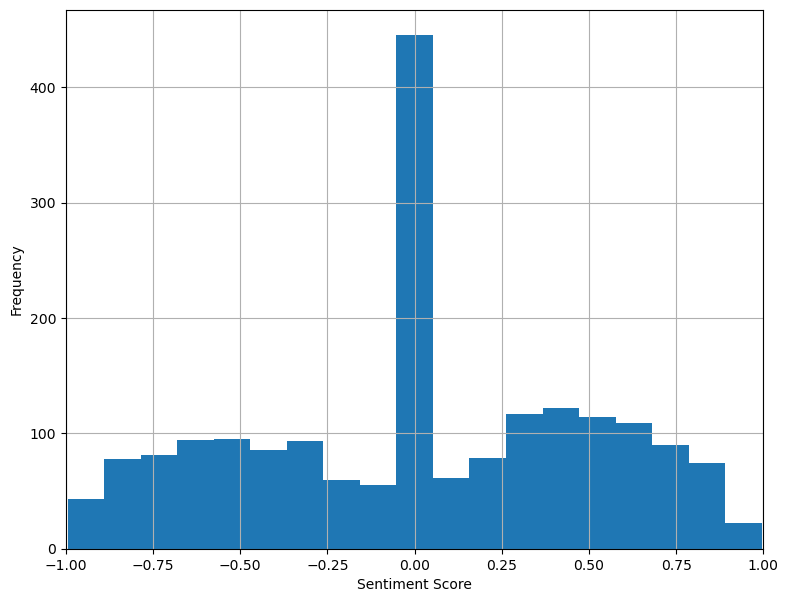

In [45]:
bins = np.linspace(-1.1, 1.1, 22)
election.sentiment.hist(bins=bins, figsize= (9, 7))
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.xlim([-1.0, 1.0])

Finally, using the VADER thresholds for positive, neutral, and negative, we can see how many articles qualify for each of those labels:

In [46]:
# Proportion of positive, negative, and neutral texts
def bin_func(x):
    if x > 0.05:
        return "positive"
    elif x < -.05:
        return "negative"
    else:
        return "neutral"
# Calculate counts
election.sentiment.apply(bin_func).value_counts()

sentiment
positive    798
negative    696
neutral     425
Name: count, dtype: int64

## Sentiment Over the Course of the Campaign

Let's examine how the compound score evolved over the course of the campaign. Do you have expectations on how this quantity might behave as the election nears? 

First, let's create a new `pandas` series which tracks the sentiment over time:

In [47]:
# change pub_date to DatetimeIndex format
election["pub_date"] = pd.to_datetime(election["pub_date"])

In [48]:
# Create a time series with publication date as the index and sentiment score as the value
sentiment_ts = pd.Series(index= election.pub_date.tolist(),
                         data = election.sentiment.tolist())

Next, we'll calculate daily and weekly averages:

In [49]:
# Resample the data with daily averages and weekly averages
daily = sentiment_ts.resample("d").mean()
weekly = sentiment_ts.resample("W").mean()

Let's plot the results. Do you notice any patterns?

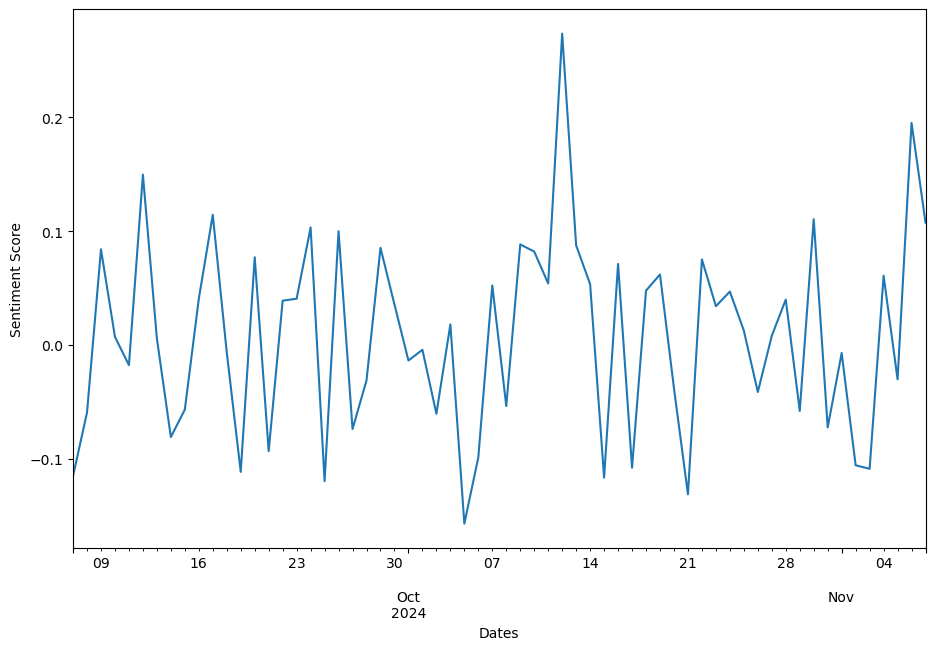

In [50]:
# Daily average sentiment of articles.
daily.plot(figsize = (11, 7))
plt.xlabel("Dates")
plt.ylabel("Sentiment Score");

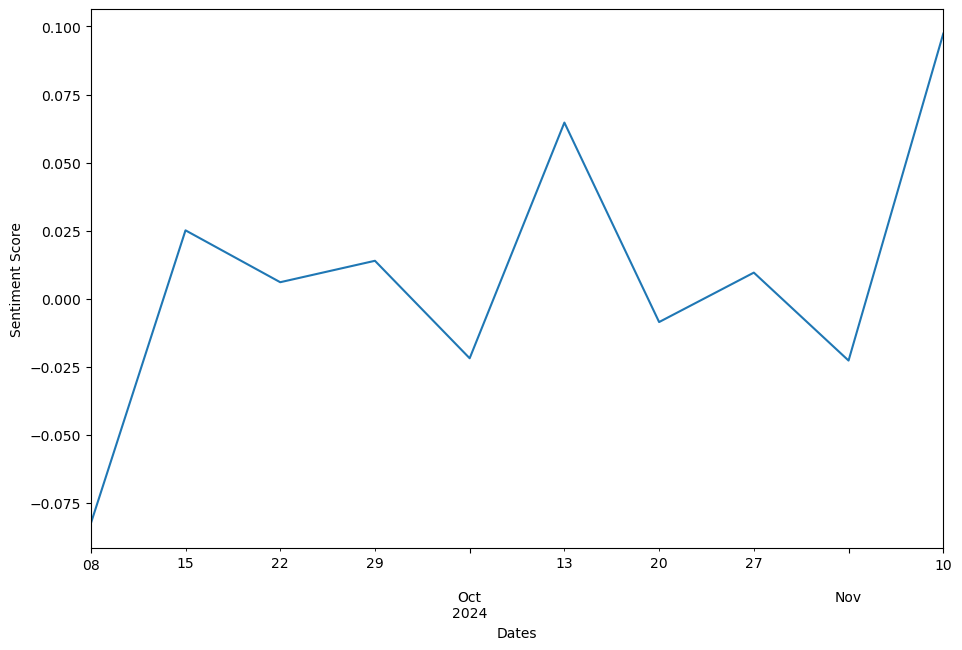

In [51]:
# Weekly average sentiment of articles.
weekly.plot(figsize = (11, 7))
plt.xlabel("Dates")
plt.ylabel("Sentiment Score");

## Handling Nested Arrays of Keywords

The NY Times has done us a favor in providing named entities in the article API results, thus relieving us of having to do the tagging ourselves. However, the data structure that it comes in can be tricky to handle. Here, we provide a short tutorial showing one way to cleanly extract keyword data.

In [52]:
# Refer to a sample article's set of keywords
election.keywords.iloc[1]

"[{'name': 'subject', 'value': 'International Relations', 'rank': 1, 'major': 'N'}, {'name': 'subject', 'value': 'Politics and Government', 'rank': 2, 'major': 'N'}, {'name': 'organizations', 'value': 'Blair, Tony, Institute for Global Change', 'rank': 3, 'major': 'N'}, {'name': 'organizations', 'value': 'Labour Party (Great Britain)', 'rank': 4, 'major': 'N'}, {'name': 'persons', 'value': 'Blair, Tony', 'rank': 5, 'major': 'N'}, {'name': 'glocations', 'value': 'Great Britain', 'rank': 6, 'major': 'N'}]"

We see a number of things here:
- Each article's keywords are laid out in a list of dictionaries.
- A dictionary tell us the name, value, rank, and major of the keyword.
- 'Name' gives the category of keyword, with give possibilities: `subject`, `persons`, `glocations`, `organizations`, and `creative_works`.
- 'Value' gives the actual keywork or phrase.
- 'Rank' indicates the relative importance of the keywork. The ordering of the list corresponds to the ranking.
- 'Major' indicates whether the keyword is a primary focus or a secondary reference.
- All articles do not all have the same number of rankings.

Let's write a function to extract keyword data based on the ranking. This function will be applied over the pandas series of keyword data.

In [53]:
import ast

# Convert the string representation of the list into actual lists of dictionaries
election['keywords'] = election['keywords'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [54]:
election["keywords"].head()

0    [{'name': 'subject', 'value': 'Presidential El...
1    [{'name': 'subject', 'value': 'International R...
2    [{'name': 'organizations', 'value': 'Telegram ...
3    [{'name': 'subject', 'value': 'Presidential El...
4    [{'name': 'glocations', 'value': 'Russia', 'ra...
Name: keywords, dtype: object

In [55]:
def rank_extractor(data, rank):
    """Extracts keyword data based on the 'rank' field."""
    if isinstance(data, list):
        for keyword in data:
            if isinstance(keyword, dict) and keyword.get("rank") == rank:
                return {"name": keyword.get("name"), "value": keyword.get("value")}
    return None

In [56]:
# Extract the first, second, and third keywords
rank1 = election.keywords.apply(lambda x: rank_extractor(x, 1))
rank2 = election.keywords.apply(lambda x: rank_extractor(x, 2))
rank3 = election.keywords.apply(lambda x: rank_extractor(x, 3))

In [57]:
# View results
rank1.head()

0    {'name': 'subject', 'value': 'Presidential Ele...
1    {'name': 'subject', 'value': 'International Re...
2    {'name': 'organizations', 'value': 'Telegram L...
3    {'name': 'subject', 'value': 'Presidential Ele...
4            {'name': 'glocations', 'value': 'Russia'}
Name: keywords, dtype: object

Let's convert these dictionaries into `pandas` Series:

In [58]:
rank1 = rank1.apply(pd.Series)
rank2 = rank2.apply(pd.Series)
rank3 = rank3.apply(pd.Series)
rank1.head()

,name,value
0,subject,Presidential Election of 2024
1,subject,International Relations
2,organizations,Telegram LLC
3,subject,Presidential Election of 2024
4,glocations,Russia


Voila! A nice clean format. Now can we conduct some light analysis:

In [59]:
# Most frequent type of keyword in ranking #1
rank1.name.value_counts()

name
subject           1314
persons            411
glocations          97
organizations       41
creative_works       2
Name: count, dtype: int64

In [60]:
# The most common keywords in ranking #1:
rank1.value.value_counts()

value
Presidential Election of 2024            536
Trump, Donald J                          129
Harris, Kamala D                         124
United States Politics and Government    119
Politics and Government                   70
                                        ... 
National Debt (US)                         1
Transgender                                1
Rogers, Michael J (1963- )                 1
Trump Organization                         1
Fluorides                                  1
Name: count, Length: 383, dtype: int64

Let's do some sentiment analysis based on which presidential candidate was the rank 1 keyword.

First, we need to join the rank1 names back to the main `election` dataframe and filter specifically for articles where the keyword is one of the candidates' names.

In [72]:
# Add the rank1 values back to your main dataframe
election['rank1_name'] = rank1['value']

# Create subsets for each candidate
trump_articles = election[election['rank1_name'].str.contains("Trump", na=False)]
harris_articles = election[election['rank1_name'].str.contains("Harris", na=False)]

print(f"Trump articles: {len(trump_articles)}")
print(f"Harris articles: {len(harris_articles)}")

Trump articles: 160
Harris articles: 125


Now let's compare the sentiment distributions using kernel density plots. What do you hypothesize the pattern to be?

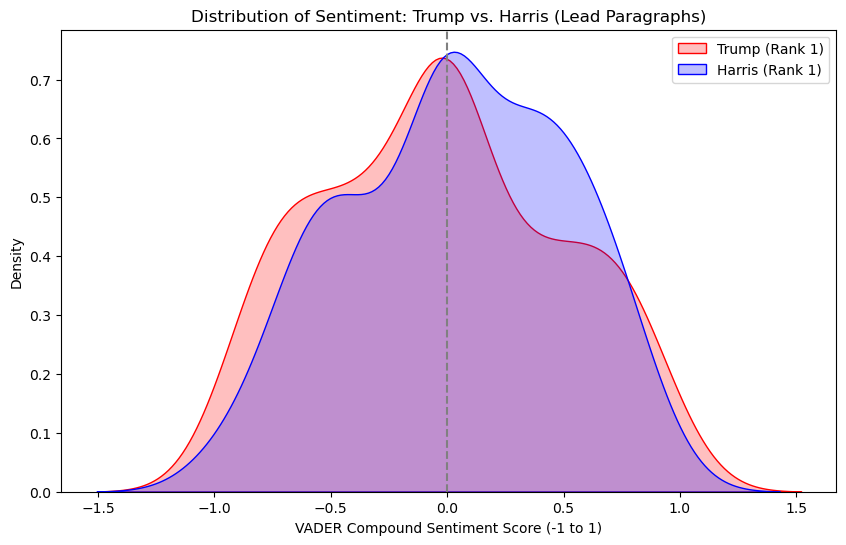

In [73]:
plt.figure(figsize=(10, 6))

# Plotting the distributions
sns.kdeplot(trump_articles['sentiment'], fill=True, label='Trump (Rank 1)', color='red')
sns.kdeplot(harris_articles['sentiment'], fill=True, label='Harris (Rank 1)', color='blue')

# Adding formatting
plt.title("Distribution of Sentiment: Trump vs. Harris (Lead Paragraphs)")
plt.xlabel("VADER Compound Sentiment Score (-1 to 1)")
plt.ylabel("Density")
plt.axvline(0, color='gray', linestyle='--') # Add a neutral line
plt.legend()
plt.show()

Suppose voters believe this means the NYT coverage is biased. Let's formally test if the averages are significantly different.

In [74]:
from scipy import stats

# 1. Prepare the data (removing any NaNs to ensure the test runs)
trump_sentiment = trump_articles['sentiment'].dropna()
harris_sentiment = harris_articles['sentiment'].dropna()

# 2. Run the Independent T-Test
# equal_var=False is used for "Welch's T-test", which is safer if the 
# group sizes or variances are different (which they likely are here).
t_stat, p_val = stats.ttest_ind(trump_sentiment, harris_sentiment, equal_var=False)

# 3. Display the results
print("--- Statistical Comparison ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


--- Statistical Comparison ---
T-statistic: -1.1916
P-value: 0.2344


What do we conclude?

A lot of articles have neutral sentiment. Could it be that there are differences in more opinionated coverage? What do the results look like if we drop neutral articles?

In [75]:
# 1. Filter out neutral scores
trump_filtered = trump_articles[(trump_articles['sentiment'] >= 0.05) | (trump_articles['sentiment'] <= -0.05)]['sentiment'].dropna()
harris_filtered = harris_articles[(harris_articles['sentiment'] >= 0.05) | (harris_articles['sentiment'] <= -0.05)]['sentiment'].dropna()

print(f"Opinionated Trump articles: {len(trump_filtered)}")
print(f"Opinionated Harris articles: {len(harris_filtered)}")

# 2. Run the Independent T-Test (Welch's T-test)
t_stat_filt, p_val_filt = stats.ttest_ind(trump_filtered, harris_filtered, equal_var=False)

# 3. Display the results
print("\n--- T-Test Results (Excluding Neutral Articles) ---")
print(f"T-statistic: {t_stat_filt:.4f}")
print(f"P-value: {p_val_filt:.4f}")

Opinionated Trump articles: 128
Opinionated Harris articles: 95

--- T-Test Results (Excluding Neutral Articles) ---
T-statistic: -1.1978
P-value: 0.2324


## Key Points

* APIs allow structured web interactions, often using URLs to query databases and retrieve data.
* API keys authenticate users, enabling access to APIs while monitoring and limiting the number of requests.
* The NYT API allows users to do things like retrieve top stories, find most shared stories, and search for stories.
* Text data acquired through APIs can be analyzed using natural language processing tools such as sentiment analysis.


# 6. Another example: The IMF API

The code in this section draws on material prepared by Lucas Fages.

There are many platforms with APIs you can explore. Some of these do not require API keys, and an example of this is the [IMF API](https://www.imf.org/external/datamapper/api/help), which allows you to retrieve country-level time series data.

Some useful information:
* [Indicator names and descriptions](https://www.imf.org/external/datamapper/api/v1/indicators)
* [Countries](https://www.imf.org/external/datamapper/api/v1/countries)

We interact with the IMF API using the `requests` package, as in the web scraping notebook.

In [76]:
import requests

Let's explore the indicators first.

In [77]:
url_1 = "https://www.imf.org/external/datamapper/api/v1/indicators"

query_1 = requests.get(url_1)

print(query_1.status_code)

200


In [78]:
# view all available keys (indicators)
query_1.json()['indicators'].keys()

dict_keys(['NGDP_RPCH', 'NGDPD', 'NGDPDPC', 'PPPGDP', 'PPPPC', 'PPPSH', 'PPPEX', 'PCPIPCH', 'PCPIEPCH', 'LP', 'BCA', 'BCA_NGDPD', '', 'LUR', 'GGXCNL_NGDP', 'GGXWDG_NGDP', 'rev', 'exp', 'prim_exp', 'ie', 'pb', 'd', 'rgc', 'rltir', 'extensive', 'intensive', 'total_theil', 'SITC1_0', 'SITC1_1', 'SITC1_2', 'SITC1_3', 'SITC1_4', 'SITC1_5', 'SITC1_6', 'SITC1_7', 'SITC1_8', 'SITC1_9', 'SITC1_total', 'DirectAbroad', 'DirectIn', 'PrivInexDI', 'PrivInexDIGDP', 'PrivOutexDI', 'PrivOutexDIGDP', 'Portfa', 'Portfl', 'EquityA', 'EquityL', 'DebtA', 'DebtL', 'OtherGov', 'OtherA', 'OtherL', 'Deriv', 'DebtForg', 'GDP', 'ka_new', 'ka_in', 'ka_out', 'FM_ka', 'Nonres_ka', 'Res_ka', 'Ka_eq', 'Ka_bo', 'Ka_mm', 'Ka_ci', 'Ka_dr', 'Ka_cc', 'Ka_fc', 'Ka_gu', 'Ka_di', 'ka_ldi', 'ka_ret', 'ka_pct', 'Reserves_ARA', 'Reserves_M2', 'Reserves_STD', 'Reserves_M', 'GRB_dummy', 'GDI_TC', 'GII_TC', 'DEBT1', 'Privatedebt_all', 'HH_ALL', 'NFC_ALL', 'PVD_LS', 'HH_LS', 'NFC_LS', 'PS_DEBT_GDP', 'NFPS_DEBT_GDP', 'GG_DEBT_GDP', '

In [79]:
# get information about a specific indicator
query_1.json()['indicators']["rev"]

{'label': 'Government revenue, percent of GDP',
 'description': 'Government revenue, percent of GDP',
 'source': 'Public Finances in Modern History Database (Dec 2025)',
 'unit': '% of GDP',
 'dataset': 'FPP'}

Let's download time series of government revenue data. We just need to call this specifically in how we set up the URL.

In [80]:
url_2 = "https://www.imf.org/external/datamapper/api/v1/rev"

query_2 = requests.get(url_2)

print(query_2.status_code)

200


This returns time series for this variable for all countries. Let's see one time series.

In [81]:
query_2.json()['values']["rev"]["FRA"]

{'1880': 13.896699905396,
 '1881': 14.286299705505,
 '1882': 13.084400177002,
 '1883': 13.408900260925,
 '1884': 13.249600410461,
 '1885': 13.227100372314,
 '1886': 12.562399864197,
 '1887': 12.901700019836,
 '1888': 12.723899841309,
 '1889': 11.926600456238,
 '1890': 11.670399665833,
 '1891': 11.469099998474,
 '1892': 11.743000030518,
 '1893': 11.956999778748,
 '1894': 12.17259979248,
 '1895': 12.574500083923,
 '1896': 11.947999954224,
 '1897': 11.597599983215,
 '1898': 11.347999572754,
 '1899': 11.227800369263,
 '1900': 11.628999710083,
 '1901': 11.74610042572,
 '1902': 11.235899925232,
 '1903': 10.82289981842,
 '1904': 11.305999755859,
 '1905': 11.338299751282,
 '1906': 10.773599624634,
 '1907': 10.242400169373,
 '1908': 10.62530040741,
 '1909': 10.326399803162,
 '1910': 10.446299552917,
 '1911': 10.399399757385,
 '1912': 9.8399496078491,
 '1913': 10.272100448608,
 '1919': 7.5736598968506,
 '1920': 16.826599121094,
 '1921': 14.854499816895,
 '1922': 12.641799926758,
 '1923': 12.0687

Let's load government expenditures as a comparison.

In [82]:
url_3 = "https://www.imf.org/external/datamapper/api/v1/exp"

query_3 = requests.get(url_3)

print(query_3.status_code)

200


Now that we have the data in hand, let's save the data for France as a dataframe and plot revenues against expenditures over time.

In [83]:
exp_fra = query_3.json()['values']["exp"]["FRA"]
rev_fra = query_2.json()['values']["rev"]["FRA"]
# convert these lists of tuples in dataframes :
revenues = pd.DataFrame.from_records(list(rev_fra.items()),
                             columns = ["year", "revenues"])

expenditures = pd.DataFrame.from_records(list(exp_fra.items()),
                             columns = ["year", "expenditures"])

In [84]:
rev_exp = revenues.merge(expenditures)
rev_exp

,year,revenues,expenditures
0,1880,13.896700,13.243300
1,1881,14.286300,13.648400
2,1882,13.084400,13.238800
3,1883,13.408900,13.636500
4,1884,13.249600,13.595300
...,...,...,...
121,2020,52.766478,61.696709
122,2021,52.879620,59.463291
123,2022,53.691451,58.428853
124,2023,51.393751,56.833359


In [85]:
# Plot these time series!
# Your code